* 아래 코드는 S1 모델의 학습 코드를 기반으로 재구성하였습니다.
* https://github.com/simplescaling/s1 

# 학습 구성

## 1. 라이브러리 설치

In [1]:
!pip install --upgrade transformers bitsandbytes peft accelerate datasets trl flash_attn vllm

  Using cached numba-0.60.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.7 kB)
  Using cached llvmlite-0.43.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.8 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 101.1 MB/s eta 0:00:001m101.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 103.9 MB/s eta 0:00:00m eta 0:00:010:01:01
Using cached numba-0.60.0-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 205.5 MB/s eta 0:00:001m292.0 MB/s eta 0:00:01
Using cached llvmlite-0.43.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (43.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 MB 84.2 MB/s eta 0:00:00m eta 0:00:01:01:01
Using cached shellingham-1.5.4-py2.py3-none-any.whl (9.8 kB)
  Attempting uninstall: jinja2
    Found existing ins

## 2. 모듈 로드

In [2]:
from datasets import load_dataset, Dataset
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, LoraConfig
from trl import SFTConfig, SFTTrainer
from typing import Dict

## 3. 모델 및 토크나이저 로드

In [3]:
model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-7B-Instruct",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")
tokenizer.pad_token = "<|fim_pad|>"
tokenizer.pad_token_id = 151662
tokenizer.padding_side = 'left'

## 4. 데이터셋 로드 및 전처리

In [5]:
dataset = load_dataset("werty1248/s1k-1.1-Ko-ReGenerated-Formatted", split='train')

In [6]:
dataset

Dataset({
    features: ['index', 'question', 'question_ko', 'reasoning_ko', 'answer_ko', 'boxed_ko', 'deepseek_answer', 'deepseek_boxed', 'gemini_naswer', 'gemini_boxed', 'solution', 'text'],
    num_rows: 984
})

In [7]:
QUERY_TEMPLATE_NOANSWER = """{Question}""".strip()

def process_cot_example(example: Dict, tokenizer):
    thinking_trajectory = example["reasoning_ko"]
    question = example["question_ko"]
    answer = example["answer_ko"]

    prompt = QUERY_TEMPLATE_NOANSWER.format(Question=question)
    answer = "Answer: " + answer if "Answer:" not in answer else answer
    text = tokenizer.apply_chat_template([
        {"role": "user", "content": prompt},
        {
            "role": "assistant", 
            "content": "<|im_start|>think\n" + thinking_trajectory.strip() + 
                       "\n<|im_start|>answer\n" + answer.strip()
        }
    ], tokenize=False)
    return dict(text=text)

In [8]:
dataset = dataset.map(lambda example: process_cot_example(example, tokenizer))
dataset = dataset.remove_columns([col for col in dataset.column_names if col != "text"]) 

In [9]:
dataset

Dataset({
    features: ['text'],
    num_rows: 984
})

In [10]:
print(dataset["text"][0])

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
유리수를 주면, 이를 기약 분수 형태로 나타내고, 그 결과 분자와 분모의 곱을 계산하세요. 0과 1 사이의 유리수 중에서 얼마의 유리수에 대해 그 결과 곱이 $20_{}^{}!$이 되겠습니까?<|im_end|>
<|im_start|>assistant
<|im_start|>think
좋아, 이 문제를 풀어봐야겠다. 문제는 0과 1 사이의 유리수를 기약 분수 형태로 나타내고, 그 분자와 분모의 곱이 20!이 되는 경우의 수를 구하는 거야. 

먼저, 유리수는 a/b 형태로 나타낼 수 있고, 0과 1 사이이니까 a < b이고, a와 b는 서로소여야 기약 분수겠지. 그리고 분자와 분모의 곱이 20!이 되어야 하니까 a * b = 20! 이라는 조건이 생기는 거야. 

그러면 문제는 결국 a와 b가 서로소이고, a < b, a*b = 20!을 만족하는 (a, b) 쌍의 개수를 찾는 거네. 

여기서 a와 b가 서로소이면서 곱이 20!이 되려면, a와 b는 20!의 약수 중에서 서로소인 두 수의 쌍이어야 해. 그리고 a < b라는 조건도 있으니까. 

그런데 a와 b가 서로소이고 a*b = N (여기서 N은 20!이야)이라면, a와 b는 N의 약수 중에서 서로소인 쌍이어야 해. 이때, a와 b는 서로소이기 때문에 N의 소인수분해에서 각 소인수들은 a나 b 중 하나에만 포함되어야 해. 

예를 들어, N = p1^e1 * p2^e2 * ... * pn^en 이라면, 각 소인수 pi는 a 또는 b 중 하나에만 속해야 해. 그래서 각 소인수마다 a에 할당할지 b에 할당할지 2가지 선택지가 생기고, 따라서 총 2^k 가지의 경우의 수가 나오겠지. 여기서 k는 N의 서로 다른 소인수의 개수야. 

하지만 문제에서는 a < b인 경우만 세야 하니까, 모든 경우의 수에서 대칭인 쌍

## 5. 토큰 길이 분석 및 시각화

In [11]:
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in dataset['text']]

max_tokens = max(token_lengths)
min_tokens = min(token_lengths)
max_text = dataset['text'][token_lengths.index(max_tokens)]
min_text = dataset['text'][token_lengths.index(min_tokens)]

print(f"최대 토큰 수: {max_tokens}")
print(f"최소 토큰 수: {min_tokens}")

최대 토큰 수: 40812
최소 토큰 수: 825


/giant-data/user/1111332/.conda/envs/jupyter/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/giant-data/user/1111332/.conda/envs/jupyter/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/giant-data/user/1111332/.conda/envs/jupyter/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/giant-data/user/1111332/.conda/envs/jupyter/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/giant-data/user/1111332/.conda/envs/jupyter/lib/python3.11/site-pa

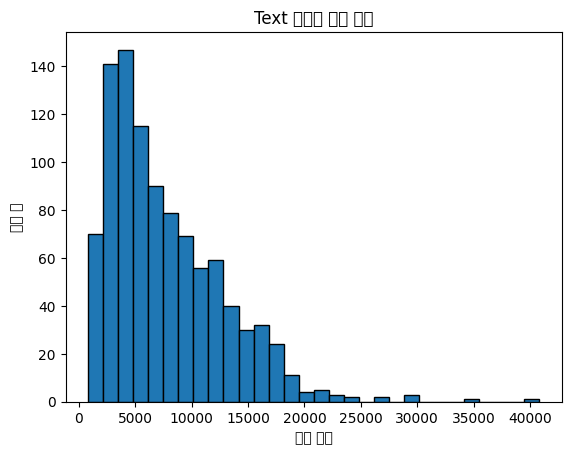

In [12]:
import matplotlib.pyplot as plt

plt.hist(token_lengths, bins=30, edgecolor='black')
plt.xlabel("토큰 개수")
plt.ylabel("샘플 수")
plt.title("Text 필드의 토큰 분포")
plt.show()

## 6. LoRA 구성 및 학습 설정

In [13]:
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=32,            
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules= ['k_proj', 'o_proj','q_proj', 'v_proj', 'up_proj', 'down_proj', 'gate_proj'],
)

In [14]:
training_arguments = SFTConfig(
    output_dir="./output",
    optim="adamw_8bit",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=32,
    gradient_checkpointing=True,
    log_level="debug",
    save_strategy="epoch",
    logging_steps=2,
    learning_rate=5e-5,
    bf16 = True,
    num_train_epochs=6,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    dataset_text_field="text",
    max_seq_length=20000,
    report_to='none'
  )

In [15]:
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=lora_config,
    args=training_arguments,
  )

Tokenizing train dataset:   0%|          | 0/984 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/984 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Using auto half precision backend
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


## 7. 학습

In [16]:
model.config.use_cache = False
trainer.train()

Currently training with a batch size of: 1
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: text. If text are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 984
  Num Epochs = 6
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 32
  Total optimization steps = 180
  Number of trainable parameters = 80,740,352


Step,Training Loss
2,0.781400
4,0.767700
6,0.749300
8,0.720300
10,0.720400
12,0.725100
14,0.745100
16,0.675200
18,0.687600


KeyboardInterrupt: 

# 추론 테스트

In [1]:
from vllm import LLM, SamplingParams
from vllm.lora.request import LoRARequest
from transformers import AutoTokenizer

## Qwen2.5-7B-Instuct 추론

In [2]:
model = LLM("Qwen/Qwen2.5-7B-Instruct", tensor_parallel_size=1,)
tok = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")

INFO 03-09 15:56:34 __init__.py:207] Automatically detected platform cuda.
INFO 03-09 15:56:44 config.py:549] This model supports multiple tasks: {'reward', 'embed', 'score', 'classify', 'generate'}. Defaulting to 'generate'.
INFO 03-09 15:56:44 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='Qwen/Qwen2.5-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 03-09 15:56:51 model_runner.py:1115] Loading model weights took 14.2487 GB
INFO 03-09 15:56:54 worker.py:267] Memory profiling takes 2.40 seconds
INFO 03-09 15:56:54 worker.py:267] the current vLLM instance can use total_gpu_memory (79.15GiB) x gpu_memory_utilization (0.90) = 71.24GiB
INFO 03-09 15:56:54 worker.py:267] model weights take 14.25GiB; non_torch_memory takes 0.09GiB; PyTorch activation peak memory takes 4.35GiB; the rest of the memory reserved for KV Cache is 52.54GiB.
INFO 03-09 15:56:54 executor_base.py:111] # cuda blocks: 61490, # CPU blocks: 4681
INFO 03-09 15:56:54 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 30.02x
INFO 03-09 15:56:57 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:15<00:00,  2.26it/s]

INFO 03-09 15:57:12 model_runner.py:1562] Graph capturing finished in 15 secs, took 0.78 GiB
INFO 03-09 15:57:12 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 20.96 seconds


In [3]:
sampling_params = SamplingParams(
    max_tokens=32768,
    min_tokens=0,
    skip_special_tokens=False,
    temperature=0.0,
)

In [4]:
prompt = """<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
다음 나열된 숫자들에서 B에 들어갈 숫자는? 61 52 63 94 46 B 차근 차근 단계별로 생각해봐<|im_end|>
<|im_start|>assistant
"""

In [5]:
o = model.generate(
    prompt,
    sampling_params=sampling_params,
)
print(prompt + o[0].outputs[0].text)

Processed prompts: 100%|██████████| 1/1 [00:06<00:00,  6.71s/it, est. speed input: 10.89 toks/s, output: 89.34 toks/s]

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
다음 나열된 숫자들에서 B에 들어갈 숫자는? 61 52 63 94 46 B 차근 차근 단계별로 생각해봐<|im_end|>
<|im_start|>assistant
이 문제를 해결하기 위해 차근차근 단계별로 생각해볼 수 있습니다. 주어진 숫자열은 61, 52, 63, 94, 46, B입니다. 이 숫자열에서 B에 들어갈 숫자를 찾기 위해 다음과 같은 단계를 따르겠습니다.

1. **차이 계산**: 먼저 주어진 숫자들 사이의 차이를 계산해봅시다.
   - 61에서 52는 9
   - 52에서 63은 11
   - 63에서 94는 31
   - 94에서 46은 -48

2. **차이의 패턴 찾기**: 계산한 차이들을 살펴보면, 9, 11, 31, -48입니다. 이 차이들 사이에는 명확한 패턴이 보이지 않지만, 그 차이들의 변화를 살펴보면, 2, 20, -79라는 패턴이 보입니다. 이는 각 차이가 직전 차이에 대해 큰 변화를 보이고 있습니다.

3. **추측과 검증**: 주어진 패턴을 기반으로, 다음 차이를 예측해봅시다. 예를 들어, -48에서 다음 차이를 계산해보면, -48에서 2, 20, -79를 고려하여 다음 차이는 -48 + 2 = -46, -46 + 20 = -26, -26 - 79 = -105 등이 될 수 있습니다. 하지만 이는 복잡해지므로, 단순한 패턴을 찾아보겠습니다.

4. **단순 패턴 찾기**: 주어진 숫자열에서 가장 간단한 패턴을 찾아보면, 61에서 52는 9, 52에서 63은 11, 63에서 94는 31, 94에서 46은 -48입니다. 이 중에서 가장 간단한 패턴은 61에서 52는 -9, 52에서 63은 +11, 63에서 94는 +31, 94에서 46은 -48입니다. 이 패턴을 이어가면, 46에서 B는 +20이 될 수 있습니다.

따라서, B에 

In [6]:
# release gpu memories
del model
del tok
del o

import gc
gc.collect()

import torch
torch.cuda.empty_cache()

## Qwen2.5-7B SFT on S1k dataset

In [7]:
MAX_TOKENS_THINKING = 20000
NUM_IGNORE = 2

In [8]:
# Load Full finetuned Model

model = LLM("./output/full/checkpoint-366", tensor_parallel_size=1,)
tok = AutoTokenizer.from_pretrained("./output/full/checkpoint-366")

INFO 03-09 15:57:45 config.py:549] This model supports multiple tasks: {'reward', 'embed', 'score', 'classify', 'generate'}. Defaulting to 'generate'.
INFO 03-09 15:57:45 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='./output/full/checkpoint-366', speculative_config=None, tokenizer='./output/full/checkpoint-366', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=./output/full/checkpoint-36

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 03-09 15:57:49 model_runner.py:1115] Loading model weights took 14.2409 GB
INFO 03-09 15:57:51 worker.py:267] Memory profiling takes 1.95 seconds
INFO 03-09 15:57:51 worker.py:267] the current vLLM instance can use total_gpu_memory (79.15GiB) x gpu_memory_utilization (0.90) = 71.24GiB
INFO 03-09 15:57:51 worker.py:267] model weights take 14.24GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 4.34GiB; the rest of the memory reserved for KV Cache is 52.65GiB.
INFO 03-09 15:57:51 executor_base.py:111] # cuda blocks: 61616, # CPU blocks: 4681
INFO 03-09 15:57:51 executor_base.py:116] Maximum concurrency for 32768 tokens per request: 30.09x
INFO 03-09 15:57:52 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:14<00:00,  2.34it/s]

INFO 03-09 15:58:06 model_runner.py:1562] Graph capturing finished in 15 secs, took 0.07 GiB
INFO 03-09 15:58:07 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 17.87 seconds


In [ ]:
# Load LoRA finetuned Model

#LORA_ADAPTER_PATH = "./output/lora/checkpoint-180"
#model = LLM(
#    "Qwen/Qwen2.5-7B-Instruct",
#    enable_lora=True,
#    max_lora_rank=16,
#    tensor_parallel_size=1,
#)

#s1_adapter = LoRARequest("s1", 1, adapter_path)
#tok = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B-Instruct")

In [9]:
prompts = [
    "다음 나열된 숫자들에서 B에 들어갈 숫자는? 61 52 63 94 46 B",
]

In [10]:
prompt = "<|im_start|>system\nYou are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>\n"
prompt += "<|im_start|>user\n" + prompts[0] + "<|im_end|>\n<|im_start|>assistant\n"

stop_token_ids = tok("<|im_start|><|im_end|>")["input_ids"]

sampling_params = SamplingParams(
    max_tokens=MAX_TOKENS_THINKING,
    min_tokens=0,
    stop_token_ids=stop_token_ids,
    skip_special_tokens=False,
    temperature=0,
)

prompt += "<|im_start|>think"

o = model.generate(
    prompt,
    sampling_params=sampling_params,
#    lora_request=s1_adapter
)

print(prompt + o[0].outputs[0].text)

Processed prompts: 100%|██████████| 1/1 [00:24<00:00, 24.79s/it, est. speed input: 2.58 toks/s, output: 89.18 toks/s]

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
다음 나열된 숫자들에서 B에 들어갈 숫자는? 61 52 63 94 46 B<|im_end|>
<|im_start|>assistant
<|im_start|>think
오, 이 문제는 숫자 패턴을 찾아서 B에 맞는 숫자를 찾는 거네. 일단 주어진 숫자들을 하나씩 살펴봐야겠어. 61, 52, 63, 94, 46, B... 

일단 각 숫자들을 자세히 보면, 아마도 어떤 규칙이 반복되는 것 같아. 예를 들어, 각 숫자가 이전 숫자와 어떤 관계가 있는지, 혹은 위치에 따라 특정한 변화가 있는지 확인해야 할 것 같아.

먼저, 숫자들의 차이를 계산해보는 건 어떨까? 예를 들어, 52에서 61이 되었고, 그 다음 63, 94, 46, B... 이렇게 되면 각각의 차이를 계산해보면 규칙이 있을 수 있겠지.

하지만 52에서 61은 9 증가, 63은 11 증가, 94는 31 증가, 46은 48 감소... 이렇게 보면 패턴이 잘 안 보이네. 다른 방법을 생각해봐야겠다.

아니면 각 숫자를 이진수로 변환해서 보는 건 어떨까? 어떤 숫자 시퀀스에서 이진수 패턴을 찾는 경우가 있으니까. 예를 들어, 각 숫자의 이진수 표현에서 1의 개수가 홀수인지 짝수인지가 규칙이 될 수 있겠지. 하지만 이 경우 각 숫자를 이진수로 바꿔서 1의 개수를 세어보자.

61은 이진수로 111101. 1의 개수는 5개. 5는 홀수.

52는 110100. 1의 개수는 2개. 2는 짝수.

63은 111111. 1의 개수는 6개. 6은 짝수.

94는 1011110. 1의 개수는 5개. 5는 홀수.

46은 1011110. 1의 개수는 5개. 5는 홀수.

그럼 B 다음의 숫자는 1의 개수가 짝수여야 하나? 그런데 현재 주어진 숫자들 중 마지막이 46인데, 46의 1의 개수는 5개(1011110)로 홀수야.

## With budget forcing

In [11]:
ignore_str = "잠깐,"
max_tokens_thinking_tmp = MAX_TOKENS_THINKING

for i in range(NUM_IGNORE):
    max_tokens_thinking_tmp -= len(o[0].outputs[0].token_ids)
    prompt += o[0].outputs[0].text + ignore_str

    sampling_params = SamplingParams(
        max_tokens=max_tokens_thinking_tmp,
        min_tokens=0,
        stop_token_ids=stop_token_ids,
        skip_special_tokens=False,
        temperature=0.0,
    )

    o = model.generate(
        prompt,
        sampling_params=sampling_params
    )

print(prompt + o[0].outputs[0].text)

Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it, est. speed input: 1011.28 toks/s, output: 83.29 toks/s]

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
다음 나열된 숫자들에서 B에 들어갈 숫자는? 61 52 63 94 46 B<|im_end|>
<|im_start|>assistant
<|im_start|>think
오, 이 문제는 숫자 패턴을 찾아서 B에 맞는 숫자를 찾는 거네. 일단 주어진 숫자들을 하나씩 살펴봐야겠어. 61, 52, 63, 94, 46, B... 

일단 각 숫자들을 자세히 보면, 아마도 어떤 규칙이 반복되는 것 같아. 예를 들어, 각 숫자가 이전 숫자와 어떤 관계가 있는지, 혹은 위치에 따라 특정한 변화가 있는지 확인해야 할 것 같아.

먼저, 숫자들의 차이를 계산해보는 건 어떨까? 예를 들어, 52에서 61이 되었고, 그 다음 63, 94, 46, B... 이렇게 되면 각각의 차이를 계산해보면 규칙이 있을 수 있겠지.

하지만 52에서 61은 9 증가, 63은 11 증가, 94는 31 증가, 46은 48 감소... 이렇게 보면 패턴이 잘 안 보이네. 다른 방법을 생각해봐야겠다.

아니면 각 숫자를 이진수로 변환해서 보는 건 어떨까? 어떤 숫자 시퀀스에서 이진수 패턴을 찾는 경우가 있으니까. 예를 들어, 각 숫자의 이진수 표현에서 1의 개수가 홀수인지 짝수인지가 규칙이 될 수 있겠지. 하지만 이 경우 각 숫자를 이진수로 바꿔서 1의 개수를 세어보자.

61은 이진수로 111101. 1의 개수는 5개. 5는 홀수.

52는 110100. 1의 개수는 2개. 2는 짝수.

63은 111111. 1의 개수는 6개. 6은 짝수.

94는 1011110. 1의 개수는 5개. 5는 홀수.

46은 1011110. 1의 개수는 5개. 5는 홀수.

그럼 B 다음의 숫자는 1의 개수가 짝수여야 하나? 그런데 현재 주어진 숫자들 중 마지막이 46인데, 46의 1의 개수는 5개(1011110)로 홀수야.

In [12]:
prompt += o[0].outputs[0].text
stop_token_ids = tok("<|im_end|>")["input_ids"]

sampling_params = SamplingParams(
    max_tokens=32768,
    min_tokens=0,
    stop_token_ids=stop_token_ids,
    skip_special_tokens=False,
    temperature=0.0,
)

o = model.generate(
    prompt,
    sampling_params=sampling_params,
)
print(prompt + o[0].outputs[0].text)

Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s, est. speed input: 13245.83 toks/s, output: 5.09 toks/s]

<|im_start|>system
You are Qwen, created by Alibaba Cloud. You are a helpful assistant.<|im_end|>
<|im_start|>user
다음 나열된 숫자들에서 B에 들어갈 숫자는? 61 52 63 94 46 B<|im_end|>
<|im_start|>assistant
<|im_start|>think
오, 이 문제는 숫자 패턴을 찾아서 B에 맞는 숫자를 찾는 거네. 일단 주어진 숫자들을 하나씩 살펴봐야겠어. 61, 52, 63, 94, 46, B... 

일단 각 숫자들을 자세히 보면, 아마도 어떤 규칙이 반복되는 것 같아. 예를 들어, 각 숫자가 이전 숫자와 어떤 관계가 있는지, 혹은 위치에 따라 특정한 변화가 있는지 확인해야 할 것 같아.

먼저, 숫자들의 차이를 계산해보는 건 어떨까? 예를 들어, 52에서 61이 되었고, 그 다음 63, 94, 46, B... 이렇게 되면 각각의 차이를 계산해보면 규칙이 있을 수 있겠지.

하지만 52에서 61은 9 증가, 63은 11 증가, 94는 31 증가, 46은 48 감소... 이렇게 보면 패턴이 잘 안 보이네. 다른 방법을 생각해봐야겠다.

아니면 각 숫자를 이진수로 변환해서 보는 건 어떨까? 어떤 숫자 시퀀스에서 이진수 패턴을 찾는 경우가 있으니까. 예를 들어, 각 숫자의 이진수 표현에서 1의 개수가 홀수인지 짝수인지가 규칙이 될 수 있겠지. 하지만 이 경우 각 숫자를 이진수로 바꿔서 1의 개수를 세어보자.

61은 이진수로 111101. 1의 개수는 5개. 5는 홀수.

52는 110100. 1의 개수는 2개. 2는 짝수.

63은 111111. 1의 개수는 6개. 6은 짝수.

94는 1011110. 1의 개수는 5개. 5는 홀수.

46은 1011110. 1의 개수는 5개. 5는 홀수.

그럼 B 다음의 숫자는 1의 개수가 짝수여야 하나? 그런데 현재 주어진 숫자들 중 마지막이 46인데, 46의 1의 개수는 5개(1011110)로 홀수야.